# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
!pip list

Package                       Version
----------------------------- -----------
absl-py                       1.3.0
aiohttp                       3.8.3
aiosignal                     1.3.1
anyio                         3.6.2
appnope                       0.1.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.1.0
astunparse                    1.6.3
async-timeout                 4.0.2
attrs                         22.1.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bayesian-optimization         1.3.1
bcrypt                        4.0.1
beautifulsoup4                4.11.1
bleach                        5.0.1
boto3                         1.26.12
botocore                      1.29.12
brotlipy                      0.7.0
cached-property               1.5.2
cachetools                    5.2.0
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.1.1
click  

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

2022-11-20 00:50:01.114950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 00:50:01.159923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [19]:
history = model.fit(train, epochs=1, validation_data=val)

2022-11-19 19:42:24.221617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:42:24.642615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:42:24.663632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:42:42.270583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:42:42.300192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6981/6981 [==============================] - ETA: 0s - loss: 0.0619

2022-11-19 22:52:43.581491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 22:52:44.144132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 22:52:44.217179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6981/6981 [==============================] - 13655s 2s/step - loss: 0.0619 - val_loss: 0.0461


In [21]:
history.history

{'loss': [0.06193598732352257], 'val_loss': [0.0461270809173584]}

In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

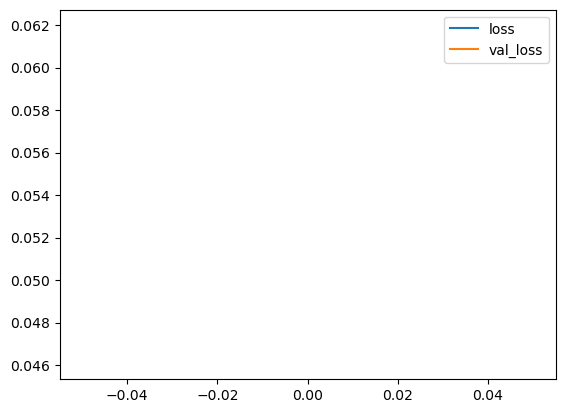

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [23]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [28]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [27]:
model.predict(np.expand_dims(input_text, 0))

2022-11-19 23:36:55.391187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 23:36:55.610933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 23:36:55.667401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 18s 18s/step


array([[0.98968226, 0.1460003 , 0.90144885, 0.02945295, 0.75966686,
        0.13492529]], dtype=float32)

In [25]:
batch = test.as_numpy_iterator().next()

In [29]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)

In [35]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 1s 1s/step


In [36]:
(res > 0.5).astype(int) 

array([[1, 0, 1, 0, 1, 0]])

In [37]:
res.shape

(1, 6)

# 4. Evaluate Model

In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 1s 1s/step


In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7784830331802368, Recall:0.729408323764801, Accuracy:0.4663991928100586


# 5. Test and Gradio

In [42]:
!pip install gradio jinja2

In [23]:
import tensorflow as tf
import gradio as gr

In [44]:
model.save('toxicity.h5')

In [16]:
model = tf.keras.models.load_model('toxicity.h5')

In [17]:
input_str = vectorizer('hey i freaken hate you!')

In [18]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [19]:
res = model.predict(np.expand_dims(input_str,0))

2022-11-20 00:50:55.728790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 00:50:55.839536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 00:50:55.857370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 18s 18s/step


In [20]:
res

array([[0.77826464, 0.03624093, 0.38410228, 0.036258  , 0.44466788,
        0.10209736]], dtype=float32)

In [21]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [24]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [25]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a6d0288755fc9661.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 1s 1s/step
